#  Natural Language Processing
## Feature Representation & Text Classification
#### Notebook By: PALLAVI BHIMTE
#### Student ID: S3758167

Version: 1.0

Environment: Python 3 and Jupyter notebook

*Libraries used:*

* pandas
* re
* numpy
* gensim
* nltk
* os
* pickle
* seaborn
* matplotlib
* pylab

## Introduction
As the description of all job ads is now pre-processed and cleaned. This notebook demonstrates the python code for generating different types of features representation for the collection of job advertisements. 

In task 2, there are total seven types of vectors built i.e., count vector, FastText unweighted, Glove unweighted, GoogleNews300 unweighted, FastText TF-IDF weighted,  Glove TF-IDF weighte and GoogleNews300 TF-IDF weighted.
A count_vectors.txt file is saved as an output to store all the count vectors generated.

In task 3, a simple machine learning model is built to classify the category of the job ads description text. For this all the details such as ID, webindex, category, title, and description of the job ad is fetched from the jobads list and stored into a dataset. An analysis of how well the machine learning model performs and comparisons based on different feature representations of the documents of all these models is evaluated. Then, to check whether adding extra information such as the title of particular job ad helps in boosting the accuracy of the model or not, classification models are built first for the title of the job advertisement only, second for the description of the job advertisement and then by considering the title and description of the job.

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Importing libraries 

In [3]:
pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 2.5 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
# Required Libraries
import re
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
nltk.download('punkt')
from itertools import chain
from nltk.probability import *
from nltk import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

import gensim
import gensim.models
from gensim import utils
from gensim import models
import gensim.downloader as api
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec, KeyedVectors


from sklearn.datasets import load_files
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=1e66ce46c647382dbab068a63dfc5d393fc881beb581322ef9e85c2d8c6b529c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12,10

### Load Files

In [7]:
# Load the file with job ad description
jobAdsFile = '/content/drive/My Drive/Task-2-and-3/job_ads.txt'
with open(jobAdsFile) as j: 
    jobAds = j.read().splitlines()

In [8]:
# Load the vocabulary file
vocabFile = '/content/drive/My Drive/Task-2-and-3/vocab.txt'
with open(vocabFile) as v: 
    vocab_formatted = v.read().splitlines()

In [9]:
# Load the file with tokenised job ad description
tokens_jobAdsFile = '/content/drive/My Drive/Task-2-and-3/tokens_job_ads.txt'
with open(tokens_jobAdsFile) as t: 
    tokens_jobAds = t.read().splitlines()

In [10]:
# First 10 entries in the jobAds list
jobAds[0:10]

['ID: 14624',
 'Category: Engineering',
 'Title: Plant Engineer',
 'Webindex: 62119057',
 'Description: established manufacturer supplier quality water treatment plants ranging basic water softeners reverse osmosis equipment customer complex water treatment solutions meet clients requirements flexibility tailoring product budgets due expansion increased workload seeking recruit planet engineer cover accounts corridor responsibilities include conducting routine sampling analysis water systems interpreting results maintenance installation chemical dosing systems servicing accounts industrial commercial industries complete accordance approved code practice ideal applicant minimum years relevant industry reverse osmosis water softeners water filters uv equipment full driving license return offering competitive package ideal',
 'ID: 31567',
 'Category: Healthcare_Nursing',
 'Title: Residential Care Worker',
 'Webindex: 66314490',
 'Description: timeout children homes rapidly expanding foref

### Functions to be used

In [11]:
# Funtion to get the ID from the Job Ads list
def getID(final_list):
  idList = list()
  for line in final_list:
    if line.find("ID") == 0: # if ID found in the beginning of the list item
      regex = re.compile(r'\d+')
      id_num = regex.findall(line)   # append the digits after ID to the idList
      idList.append(id_num)
  return idList    

In [12]:
# Funtion to get the web index from the Job Ads list
def getWebindexList(final_list):
  webIndexList = list()
  for line in final_list:
    if line.find("Webindex") == 0: # if Webindex found in the beginning of the list item
      regex = re.compile(r'\d+')
      web_index_num = regex.findall(line)   # append the digits after ID to the webIndexList 
      webIndexList.append(web_index_num)
  return webIndexList

In [13]:
# Funtion to get the title from the Job Ads list
def getTitle(final_list):
  titleList = list()
  for line in final_list:
    if line.find("Title") == 0: # if Title found in the beginning of the list item
      title_value = line[7:]   
      titleList.append(title_value) # append the letters after 7th index value to the titleList
    else:
      continue
  return titleList  

In [14]:
# Funtion to get the category from the Job Ads list
def getCategory(final_list):
  categoryList = list()
  for line in final_list:
    if line.find("Category") == 0: # if Category found in the beginning of the list item
      cat_value = line[10:]   
      categoryList.append(cat_value) # append the letters after 10th index value to the categoryList
  return categoryList 

In [15]:
# Function to tokenize the description
def tokenizeDescription(raw_description):
    # raw_description = lowerCase(raw_description)
    sentences = sent_tokenize(raw_description) # tokenize raw description
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?" # regex for the strings
    tokenizer = RegexpTokenizer(pattern) # tokenize strings with regex pattern
    token_lists = [tokenizer.tokenize(sen) for sen in sentences] # return tokenized words in form of list
    # merge them into a list of tokens
    tokenizeDescription = list(chain.from_iterable(token_lists))
    return tokenizeDescription

In [16]:
# Function to return the tokenized description list
def getAllDescList(final_list):
  desList = list()
  for line in final_list:
    if line.find("Description") == 0:
      tokens = tokenizeDescription(line)
      tokens.remove('Description')
      desList.append(tokens)
  return desList

## Create Data Frame

In [17]:
# Check the length of all list matches to form a dataframe later
id = getID(jobAds)
print("Length of total Ids in the ID list",len(id))
web_index = getWebindexList(jobAds)
print("Length of total webindex in the web_index list",len(web_index))
category = getCategory(jobAds)
print("Length of total categories in the category list", len(category))
title = getTitle(jobAds)
print("Length of total titles in the title list", len(title))
job_ads_nested_list = getAllDescList(jobAds)
print("Length of total descriptions in the job_ads_nested_list list", len(job_ads_nested_list))


Length of total Ids in the ID list 55449
Length of total webindex in the web_index list 55449
Length of total categories in the category list 55449
Length of total titles in the title list 55449
Length of total descriptions in the job_ads_nested_list list 55449


The lists are now ready to form a dataset as shown below:

In [18]:
# Initialise a dataframe variable
data = pd.DataFrame()
description_file = '/content/drive/My Drive/Task-2-and-3/tokens_job_ads.txt'
with open(description_file) as txt:
    job_desc = txt.read().splitlines() # reading a list of strings, each for a document/article
tokenized_desc = [a.split(' ') for a in job_desc]

from itertools import chain
data['id'] = list(chain.from_iterable(id))
data['category'] = category
data['title'] = title
data['web_index'] = list(chain.from_iterable(web_index))
data['job_desc'] = job_desc
data['tk_desc'] = tokenized_desc
data.sample(n = 5)

,id,category,title,web_index,job_desc,tk_desc
53253,01343,IT,MS Web Developer,66923232,ms web developer permanent milton keynes outst...,"[ms, web, developer, permanent, milton, keynes..."
7548,23700,Accounting_Finance,Partqualified,67768462,immediately months suit part qualified account...,"[immediately, months, suit, part, qualified, a..."
50772,12360,IT,SQL / NET Developer,71856422,title sql net developer destination london neg...,"[title, sql, net, developer, destination, lond..."
24754,15822,Engineering,Engineer Manufacturing ****,67946327,introduction automotive oem seeks manufacturin...,"[introduction, automotive, oem, seeks, manufac..."
46032,46969,Teaching,Nanny afterschool,71343288,wilmslow school hours collection days week mon...,"[wilmslow, school, hours, collection, days, we..."


The above dataframe has columns for job id, category, title, webindex, job description and tokenized job description.

In [19]:
# Save dataframe
# data.to_csv('/content/drive/My Drive/pickle-data/desc_pickle/data.csv')

# Task 2. Generate Feature Representations for Job Advertisement Descriptions

In [20]:
#----UNWEIGHTED FUNCTION----
def gen_docVecs(wv,tk_txts): # document vector representaion for every document
    docs_vectors = pd.DataFrame() # empty datafram initialised
    
    for i in range(0,len(tk_txts)):
        tokens = tk_txts[i]
        temp = pd.DataFrame()  # initialise a dataframe
        for w_ind in range(0, len(tokens)): #  loop through every doc and split through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # check if word in embedding and googlew2v will give weights and proceed
                temp = temp.append(pd.Series(word_vec), ignore_index = True) # append if word present
            except:
                pass
        doc_vector = temp.sum() # sum of all columns
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append every document value to dataframe
    return docs_vectors

## 2.1 Count Vectors

In [21]:
# get a nested list after getting all the descriptions from the jobads list
job_ads_nested_list = getAllDescList(jobAds)

In [ ]:
# Pickle out job_ads_nested_list
pickle_out = open("/content/drive/My Drive/pickle-data/desc_pickle/job_ads_nested_list.pickle", "wb")
pickle.dump(job_ads_nested_list, pickle_out)

In [ ]:
# Pickle out job_ads_nested_list
pickle_in = open("/content/drive/My Drive/pickle-data/desc_pickle/job_ads_nested_list.pickle", "rb")
job_ads_nested_list = pickle.load(pickle_in)

In [22]:
# Read the vocabulary file with only words
word_vocabFile = '/content/drive/My Drive/Task-2-and-3/words-desc-vocab.txt'
with open(word_vocabFile) as v: 
    vocab = v.read().splitlines()

In [23]:
vocab[:5]

["a'level", 'aa', 'aaa', 'aaappointments', 'aab']

In [24]:
# bind words for each review
joined_job = [' '.join(job) for job in job_ads_nested_list]
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # initialise the CountVectorizer
count_features = cVectorizer.fit_transform(joined_job) # transform joined job
count_features.shape # return shape of count_features

(55449, 40038)

In [25]:
# sparse matrix form count_features
count_features

<55449x40038 sparse matrix of type '<class 'numpy.int64'>'
	with 4734001 stored elements in Compressed Sparse Row format>

In [ ]:
# Pickle out count_features
pickle_out = open("/content/drive/My Drive/pickle-data/desc_pickle/count_features.pickle", "wb")
pickle.dump(count_features, pickle_out)

In [ ]:
# Pickle in count_features
pickle_in = open("/content/drive/My Drive/pickle-data/desc_pickle/count_features.pickle", "rb")
count_features = pickle.load(pickle_in)

In [26]:
# pickle_in = open("desc_pickle/count_features.pickle", "rb")
# count_features = pickle.load(pickle_in)

The `gen_docVecs` function given below generates vector representation for all documents. It initialises an empty datframe named `doc_vectors`, and for every item

## 2.2 FastText Embeddings
FastText language model trained based on the provided job advertisement descriptions, with a 200 embedding dimension.

In [27]:
## Cell takes 5 minutes 27 seconds to run

# specify path to the corpus file
jobs_corpus_file = '/content/drive/My Drive/Task-2-and-3/tokens_job_ads.txt'

# fast text model initialised
jobsFT = FastText(vector_size=100) 

# build vocabulary
jobsFT.build_vocab(corpus_file=jobs_corpus_file)

# train model
jobsFT.train(
    corpus_file=jobs_corpus_file, epochs=jobsFT.epochs,
    total_examples=jobsFT.corpus_count, total_words=jobsFT.corpus_total_words,
)

# jobsFT
print(jobsFT)

# FastText word vector
jobsFT_wv = jobsFT.wv

# jobsFT_wv
print(jobsFT_wv)

FastText(vocab=22816, vector_size=100, alpha=0.025)


In [ ]:
#Save the FastText model
jobsFT.save("/content/drive/My Drive/Task-2-and-3/jobsFT.model")

In [ ]:
jobsFT.save("/content/drive/My Drive/Models/jobsFT.model")

### 2.2.1 FastText UNWEIGHTED

In [ ]:
jobsFT = FastText.load("/content/drive/My Drive/Task-2-and-3/jobsFT.model")
print(jobsFT)
jobsFT_wv= jobsFT.wv

FastText(vocab=22816, vector_size=100, alpha=0.025)


In [28]:
jobsFT_dvs = gen_docVecs(jobsFT_wv,data['tk_desc'])
jobsFT_dvs.isna().any().sum()

0


In [ ]:
jobsFT.save("/content/drive/My Drive/Models/jobsFT_dvs.model")

In [ ]:
# Pickle out jobsFT_dvs list
pickle_out = open("/content/drive/My Drive/pickle-data/jobsFT_dvs.pickle", "wb")
pickle.dump(jobsFT_dvs, pickle_out)

## 2.3 GloVe 200D 

In [ ]:
!unzip "/content/drive/My Drive/Task-2-and-3/glove.zip"

In [30]:
#  specify path to the glove embedding file
path_to_glove_file = os.path.join("glove/glove.6B.200d.txt") 

glove_wv = {} # initialise dictionary
with open(path_to_glove_file, encoding="utf-8") as f: # open file with word embedding
    for line in f:
        word, coefs = line.split(maxsplit=1)  
        coefs = np.fromstring(coefs, "f", sep=" ")
        # mapping for word vector embedding
        glove_wv[word] = coefs 

print("Found %s word vectors." % len(glove_wv))

Found 400000 word vectors.


### 2.3.1 Glove UNWEIGHTED

In [31]:
# glove_dvs unweighted
glove_dvs = gen_docVecs(glove_wv,data['tk_desc'])
glove_dvs.isna().any().sum()

0


In [ ]:
# Pickle out glove_dvs
pickle_out = open("/content/drive/My Drive/pickle-data/glove_dvs.pickle", "wb")
pickle.dump(glove_dvs, pickle_out)

## 2.4 GoogleNews 300 Embeddings

In [ ]:
# 12 minutes 6 seconds
preTW2v_wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### 2.4.1 GoogleNews300 UNWEIGHTED

In [32]:
# GoogleNews300 unweighted
preTW2v_dvs = gen_docVecs(preTW2v_wv,data['tk_desc']) 
preTW2v_dvs.isna().any().sum()

0


In [ ]:
# Pickle out preTW2v_dvs
pickle_out = open("/content/drive/My Drive/pickle-data/preTW2v_dvs.pickle", "wb")
pickle.dump(preTW2v_dvs, pickle_out)

## 2.5 WEIGHTED - Vectors

### 2.5.1 Define Functions

In [33]:
# Read the vocabulary file containing only words
vocabFile = '/content/drive/My Drive/Task-2-and-3/words-desc-vocab.txt'
with open(vocabFile) as v: 
    vocab_words = v.read().splitlines()

In [34]:
# first 5 words in the list
vocab_words[:5]

["a'level", 'aa', 'aaa', 'aaappointments', 'aab']

In [35]:
# Initialise TF-IDF vectorizer for Weighted vectors
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab_words) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform(joined_job) # generate the tfidf vector representation for all articles
print("The shape of TF-IDF features: ", tfidf_features.shape)
print("The type of TF-IDF features: ", type(tfidf_features))

The shape of TF-IDF features:  (55449, 40038)
The type of TF-IDF features:  <class 'scipy.sparse.csr.csr_matrix'>


In [37]:
# function to write vector file
def write_vectorFile(data_features,filename):
    num = data_features.shape[0] # doc num
    out_file = open(filename, 'w') # open file and save vector file
    for a_ind in range(0, num): 
        for f_ind in data_features[a_ind].nonzero()[1]: # every word having non zero entry in data feature
            value = data_features[a_ind][0,f_ind] # retrieve value entry from data features
            
            out_file.write("{}:{} ".format(f_ind,value)) # write entry in word_index:value
        out_file.write('\n') # start new line
    out_file.close() # close file

In [ ]:
# 10 minutes 20 seconds
tVector_file = "/content/drive/My Drive/Task-2-and-3/jobAds_tVector.txt"
test_write = write_vectorFile(tfidf_features,tVector_file) # write the tfidf vector to file

In [38]:
# Function to generate vocabulary index
def gen_vocIndex(voc_filename):
    with open(voc_filename) as vocf: 
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()] #  line to 'index,word'
    return {int(vi[1]):vi[0] for vi in voc_Ind}


# Generates the w_index:word dictionary
voc_filename = '/content/drive/My Drive/Task-2-and-3/vocab.txt' # path for the vocabulary
voc_dict = gen_vocIndex(voc_filename)


In [39]:
# GET WEIGHTED VECTORS
def doc_wordweights(fName_tVectors, voc_dict):
    # store the  word:weight dictionaries
    tfidf_weights = [] 
    
    with open(fName_tVectors) as tVecf: 
        # string format 'word_index:weight' of tfidf vector
        tVectors = tVecf.read().splitlines() 
    for tv in tVectors: 
        tv = tv.strip()

        # list of 'word_index:weight' entries
        weights = tv.split(' ') 

        # change the format of weight to a list of '[word_index,weight]' entries
        weights = [w.split(':') for w in weights] 

        # construct the weight dictionary, where each entry is 'word:weight'
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} 
        
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = "/content/drive/My Drive/Task-2-and-3/jobAds_tVector.txt"
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict)

In [40]:
# --------WEIGHTED FUNCTION--------
# extended version of the `gen_docVecs` function

# generate vector representation for documents
def gen_docVecs(wv,tk_txts,tfidf = []):
    # creating empty final dataframe
    docs_vectors = pd.DataFrame() 

    for i in range(0,len(tk_txts)):
        # get the list of distinct words of the document
        tokens = list(set(tk_txts[i])) 
        # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        temp = pd.DataFrame()  

        # looping through each word of a single document and spliting through space
        for w_ind in range(0, len(tokens)): 
            try:
                word = tokens[w_ind]
                word_vec = wv[word] 
                
                # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                if tfidf != []:
                    word_weight = float(tfidf[i][word])
                else:
                    word_weight = 1
                temp = temp.append(pd.Series(word_vec*word_weight), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        # take the sum of each column(w0, w1, w2,........w300)
        doc_vector = temp.sum() 

        # append each document value to the final dataframe
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) 
    return docs_vectors


### 2.5.2 GoogleNews300 Weighted

In [ ]:
# GOOGLE --- 2 hours
weighted_preTW2v_dvs = gen_docVecs(preTW2v_wv,data['tk_desc'],tfidf_weights)
weighted_preTW2v_dvs.isna().any().sum() 

0

In [ ]:
# Pickle out weighted_preTW2v_dvs
pickle_out = open("/content/drive/My Drive/pickle-data/weighted_preTW2v_dvs.pickle", "wb")
pickle.dump(weighted_preTW2v_dvs, pickle_out)

### 2.5.3 Glove weighted

In [ ]:
# GLOVE
weighted_preTGloVe_dvs = gen_docVecs(glove_wv,data['tk_desc'],tfidf_weights)
weighted_preTGloVe_dvs.isna().any().sum()

0

In [ ]:
# Pickle out weighted_preTGloVe_dvs
pickle_out = open("/content/drive/My Drive/pickle-data/weighted_preTGloVe_dvs.pickle", "wb")
pickle.dump(weighted_preTGloVe_dvs, pickle_out)

### 2.5.4 FastText Weighted

In [ ]:
# FastText WEIGHTED---
weighted_jobsFT_dvs = gen_docVecs(jobsFT_wv,data['tk_desc'],tfidf_weights)
weighted_jobsFT_dvs.isna().any().sum()

0

In [ ]:
# Pickle out weighted_jobsFT_dvs 
pickle_out = open("/content/drive/My Drive/pickle-data/weighted_jobsFT_dvs.pickle", "wb")
pickle.dump(weighted_jobsFT_dvs, pickle_out)

## Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [41]:
vocab_list = getAllDescList(jobAds)
words = list(chain.from_iterable(vocab_list)) # we put all the tokens in the corpus in a single list
vocab = sorted(list(set(words))) # compute the vocabulary by converting the list of words/tokens to a set, i.e., giving a set of unique words

len(vocab)

40038

In [42]:
vocab[0:10]

["a'level",
 'aa',
 'aaa',
 'aaappointments',
 'aab',
 'aac',
 'aacc',
 'aae',
 'aah',
 'aak']

In [ ]:
def findTermFreqWordsForOutput(descList):
  term_fd = FreqDist(descList)
  return term_fd

# code to save output data...
def formatOutput(newlist, path):
  regex = re.compile(r'\d+')
  out_file = open(path, "w")
  for match in newlist:
    if match.find("Webindex") == 0:
      web_index = regex.findall(match)
      web_index = ''.join(web_index)
      out_file.write("#" + str(web_index) + ",")

    elif match.find("Description") == 0:
      tokenized = tokenizeDescription(match)
      FreqWords = findTermFreqWordsForOutput(tokenized)
      keys = FreqWords.keys()
      values = FreqWords.values()
      
      formatLine = list()

      listValueIndex = list()
      listKey = list()

      for word in values: 
        listValueIndex.append(word)

      for word in keys:
        listKey.append(word)

      for word in listKey: 
        keyIndex = listKey.index(word)
        index = vocab.index(word.lower())
        formatLine.append(str(index) + ":" + str(listValueIndex[keyIndex]))
      
      formatLine = ','.join(formatLine)

      out_file.write(str(formatLine) + "\n")
    else:
      continue
  
  out_file.close()
  return formatList


formatList = formatOutput(jobAds, "/content/drive/My Drive/Task-2-and-3/count_vectors.txt")

# Task 3. Job Advertisement Classification

In [43]:
# load pickle files
#---- FastText Unweighted-----
pickle_in = open("/content/drive/My Drive/pickle-data/jobsFT_dvs.pickle", "rb")
jobsFT_dvs = pickle.load(pickle_in)

#-----Glove Unweighted------
pickle_in = open("/content/drive/My Drive/pickle-data/glove_dvs.pickle", "rb")
glove_dvs = pickle.load(pickle_in)

#-----GoogleNews Unweighted-----
pickle_in = open("/content/drive/My Drive/pickle-data/preTW2v_dvs.pickle", "rb")
preTW2v_dvs = pickle.load(pickle_in)

# #------FastText Weighted------
pickle_in = open("/content/drive/My Drive/pickle-data/weighted_jobsFT_dvs.pickle", "rb")
weighted_jobsFT_dvs = pickle.load(pickle_in)

# #-----Glove Weighted------
pickle_in = open("/content/drive/My Drive/pickle-data/weighted_preTGloVe_dvs.pickle", "rb")
weighted_preTGloVe_dvs = pickle.load(pickle_in)

# #-----GoogleNews Weighted-----
pickle_in = open("/content/drive/My Drive/pickle-data/weighted_preTW2v_dvs.pickle", "rb")
weighted_preTW2v_dvs = pickle.load(pickle_in)

Number of documents per category:
 IT                          14353
Healthcare_Nursing           8808
Engineering                  8210
Accounting_Finance           7407
Sales                        5349
Hospitality_Catering         4788
Teaching                     3779
PR_Advertising_Marketing     2755
Name: category, dtype: int64


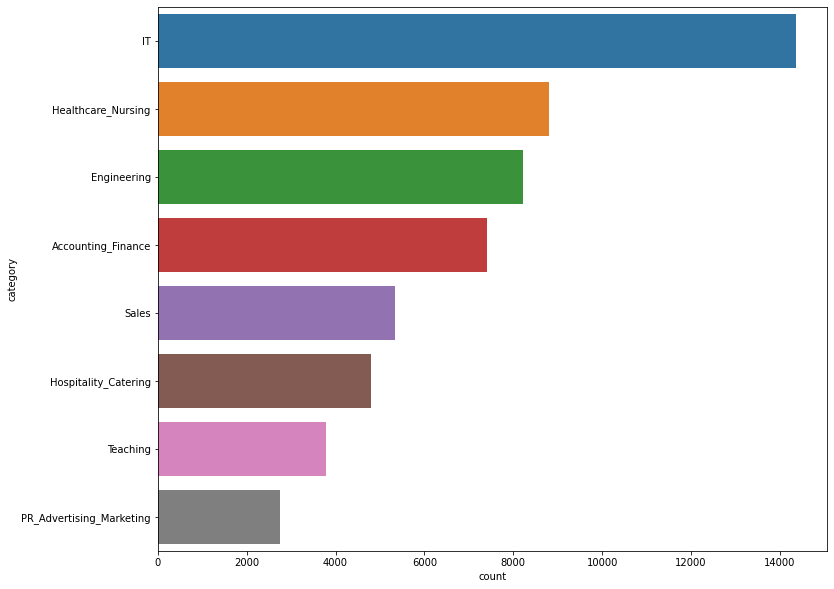

In [44]:
print("Number of documents per category:\n", data['category'].value_counts())
ax = sns.countplot(y="category", data=data, order = data['category'].value_counts().index)
ax

## 3.1 tSNE Plots
With the help of t-distributed stochastic neighbor embedding, the visualisations is plotted for heavy dimensioned data by specifying a location to every datapoint in 2D or 3D map.


In [47]:
# Function to plot the tsne grpahs
def plot_TSNE(labels,features): 
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'midnightblue', 'green', 'darkgrey', 'orange', 'red', 'cyan', 'black']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

In [ ]:
# pickle_in = open("desc_pickle/count_features.pickle", "rb")
# count_features = pickle.load(pickle_in)

# data= pd.read_csv('desc_pickle/data.csv', index_col=0)
# data[:5]

,id,category,title,web_index,job_desc,tk_desc
0,14624,Engineering,Plant Engineer,62119057,established manufacturer supplier quality wate...,"['established', 'manufacturer', 'supplier', 'q..."
1,31567,Healthcare_Nursing,Residential Care Worker,66314490,timeout children homes rapidly expanding foref...,"['timeout', 'children', 'homes', 'rapidly', 'e..."
2,50131,Hospitality_Catering,CHEF DE RANG FOR MICHELIN STARRED RESTAURANT,69182387,french restaurant club gascon michelin establi...,"['french', 'restaurant', 'club', 'gascon', 'mi..."
3,31419,Healthcare_Nursing,Inpatient Ward Team Leader,64752715,inpatient ward leader description patient lead...,"['inpatient', 'ward', 'leader', 'description',..."
4,47238,Teaching,Information Services Support Analyst,71792012,information details relating selected review i...,"['information', 'details', 'relating', 'select..."


The following tSNE plot is for count vectors(count_features) for description vs job categories: 


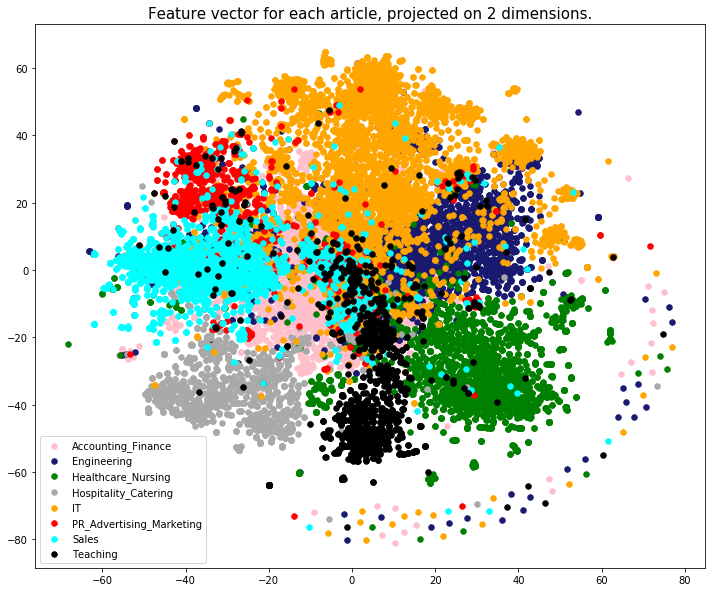

In [ ]:
# RUN THIS REMOTE
# tSNE plot for COUNT vector for description vs job categories
from sklearn.manifold import TSNE
print("The following tSNE plot is for count vectors(count_features) for description vs job categories: ")
plot_TSNE(data['category'],count_features.toarray())

The following tSNE plot is for FastText document vectors(jobsFT_dvs) vs job categories: 


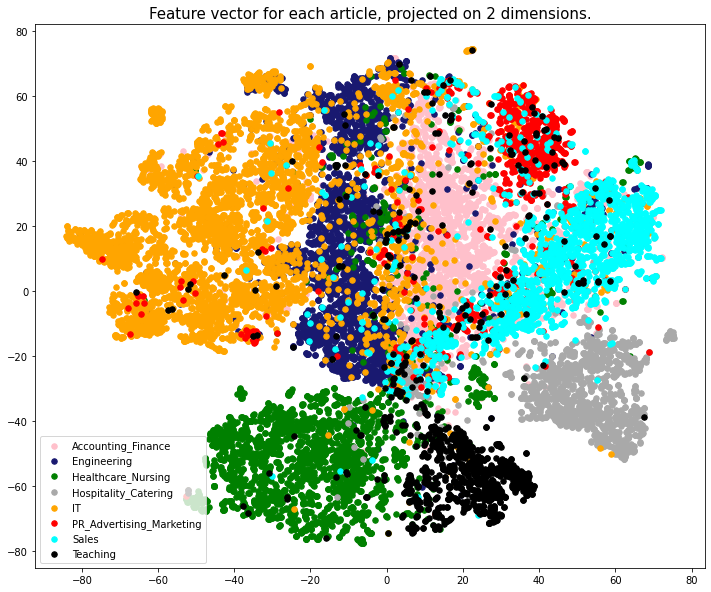

In [48]:
# tSNE plot for FastText unweighted
print("The following tSNE plot is for FastText document vectors(jobsFT_dvs) vs job categories: ")
plot_TSNE(data['category'],jobsFT_dvs.to_numpy())

The following tSNE plot is for unweighted Glove document vectors(glove_dvs) vs job categories: 


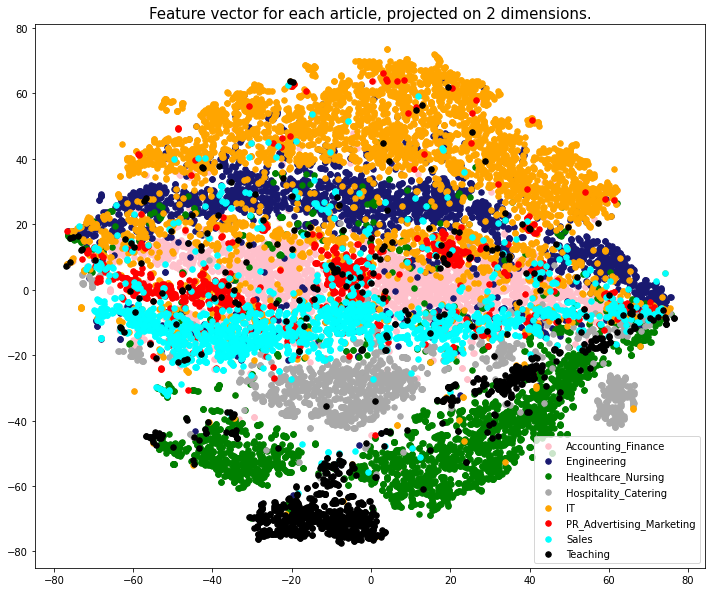

In [49]:
# tSNE plot for Glove unweighted
print("The following tSNE plot is for unweighted Glove document vectors(glove_dvs) vs job categories: ")
plot_TSNE(data['category'],glove_dvs.to_numpy())

The following tSNE plot is for unweighted GoogleNews300 document vectors(preTW2v_dvs) vs job categories: 


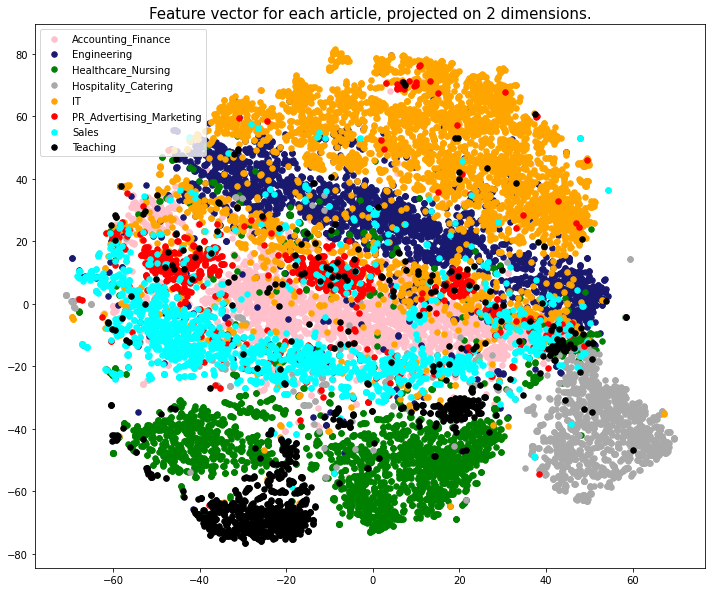

In [50]:
# tSNE plot for GoogleNews300 unweighted
print("The following tSNE plot is for unweighted GoogleNews300 document vectors(preTW2v_dvs) vs job categories: ")
plot_TSNE(data['category'],preTW2v_dvs.to_numpy())

The following tSNE plot is for weighted FastText document vectors(weighted_jobsFT_dvs) vs job categories: 


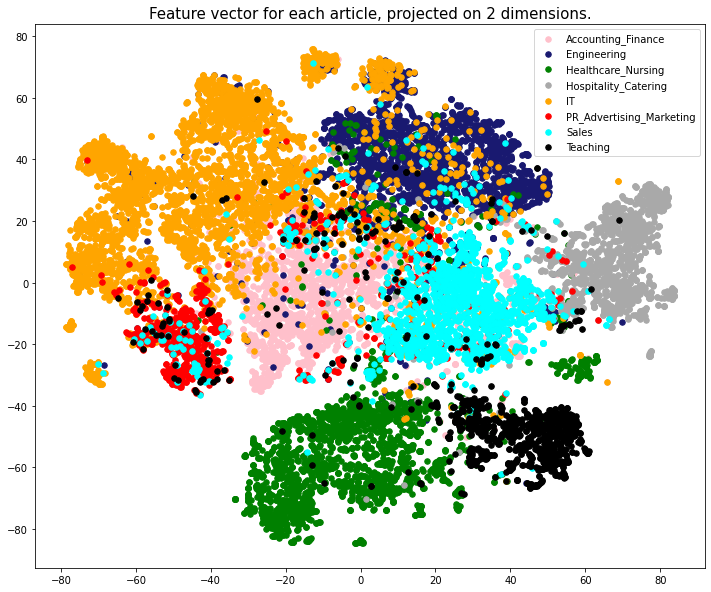

In [51]:
# tSNE plot for FastText weighted
print("The following tSNE plot is for weighted FastText document vectors(weighted_jobsFT_dvs) vs job categories: ")
plot_TSNE(data['category'],weighted_jobsFT_dvs.to_numpy())

The following tSNE plot is for weighted Glove document vectors(weighted_preTGloVe_dvs) vs job categories: 


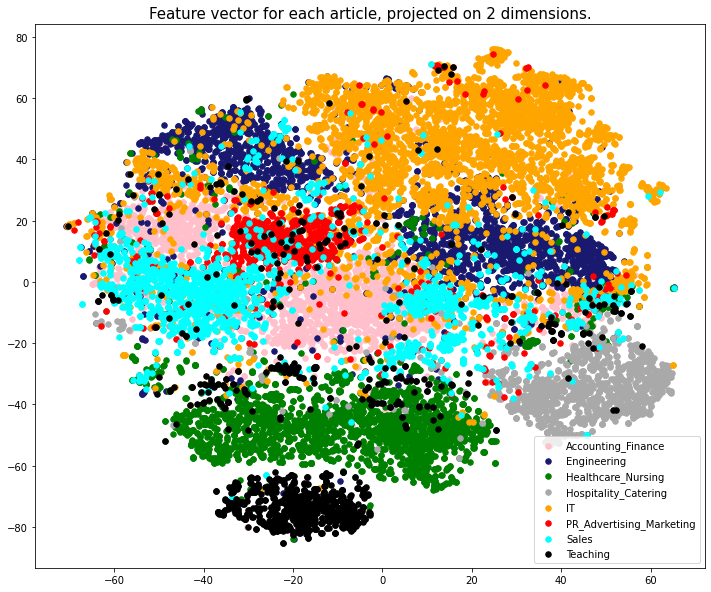

In [52]:
# tSNE plot for Glove weighted
print("The following tSNE plot is for weighted Glove document vectors(weighted_preTGloVe_dvs) vs job categories: ")
plot_TSNE(data['category'],weighted_preTGloVe_dvs.to_numpy())

The following tSNE plot is for weighted GoogleNews300 document vectors(weighted_preTW2v_dvs) vs job categories: 


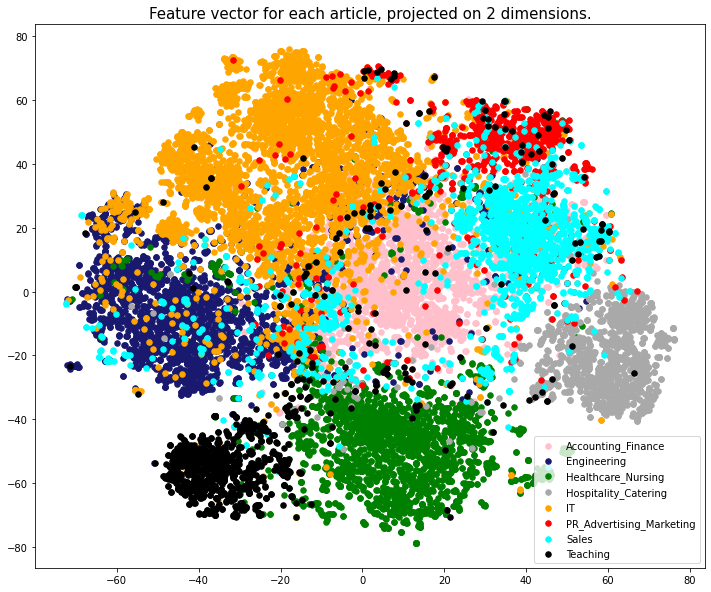

In [53]:
# tSNE plot for count features weighted
print("The following tSNE plot is for weighted GoogleNews300 document vectors(weighted_preTW2v_dvs) vs job categories: ")
plot_TSNE(data['category'],weighted_preTW2v_dvs.to_numpy())

## 3.2 Perform Logistic Regression

In [54]:
# Run Logistic Regression on count vector feature representation
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(count_features, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
count_feature_model = LogisticRegression(max_iter = 5000, random_state = seed)
count_feature_model.fit(X_train, y_train)
count_feature_model.score(X_test, y_test)

0.8757309142576097

In [55]:
# Run Logistic Regression on FastText Unweighted feature representation
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(jobsFT_dvs, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
fastText_uw_model = LogisticRegression(max_iter = 5000, random_state = seed)
fastText_uw_model.fit(X_train, y_train)
fastText_uw_model.score(X_test, y_test)

0.8642548773157003

In [56]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(glove_dvs, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
glove_uw_model = LogisticRegression(max_iter = 5000, random_state = seed)
glove_uw_model.fit(X_train, y_train)
glove_uw_model.score(X_test, y_test)

0.850592928575332

In [57]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(preTW2v_dvs, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
google_uw_model = LogisticRegression(max_iter = 5000, random_state = seed)
google_uw_model.fit(X_train, y_train)
google_uw_model.score(X_test, y_test)

0.8575331985354391

In [58]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(weighted_jobsFT_dvs, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
fastText_w_model = LogisticRegression(max_iter = 5000, random_state = seed)
fastText_w_model.fit(X_train, y_train)
fastText_w_model.score(X_test, y_test)

0.8673698016285043

In [59]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(weighted_preTGloVe_dvs, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
glove_w_model = LogisticRegression(max_iter = 5000, random_state = seed)
glove_w_model.fit(X_train, y_train)
glove_w_model.score(X_test, y_test)

0.8502650418055632

In [60]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(weighted_preTW2v_dvs, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
google_w_model = LogisticRegression(max_iter = 5000, random_state = seed)
google_w_model.fit(X_train, y_train)
google_w_model.score(X_test, y_test)

0.863763047161047

## 3.3 Language Model Comparison for different features
Comparing LogisticRegression Models trained with different feature representations

|Model Name| Accuracy|
|:-|:-|
|Count Vector| 87.57%|
|FastText Unweighted| 86.42%|
|Glove Unweighted| 85.05%|
|GoogleNews300 Unweighted| 85.75%|
|FastText TF-IDF Weighted| 86.73%|
|Glove TF-IDF Weighted| 85.02%|
|GoogleNews300 TF-IDF Weighted| 86.37%|

By looking at the accuracies in the above table, it is evident that the logistric regression model with count vector feature representation gives more significant information as it returned an accuracy of 87.57%

## 3.4 Provide More Information


### 3.4.1 Only Title

In [61]:
# Pre-processing on Title 
stopwords = []
with open('/content/drive/My Drive/stopwords_en.txt', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

def tokenizeText(raw_text):
    # raw_description = lowerCase(raw_description)
    sentences = sent_tokenize(raw_text) # tokenize raw description
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?" # regex for the strings
    tokenizer = RegexpTokenizer(pattern) # tokenize strings with regex pattern
    token_lists = [tokenizer.tokenize(sen) for sen in sentences] # return tokenized words in form of list
    # merge them into a list of tokens
    final_text_list = list(chain.from_iterable(token_lists))
    return final_text_list

def lowerCase(raw_description):
  lower_string = raw_description.lower() # convert all strings in the title to lower case
  return lower_string

def remove_short_words(tokens):
  new_tokens = list() # list without short words
  for t in tokens:
    if len(t) >= 2:
      new_tokens.append(t) # append words with length more than 2
  return new_tokens

def removeStopWords(match):
  list_without_stopwords = list() # initialise list without stopwords
  for word in match:
    if word not in stopwords:
      list_without_stopwords.append(word) # add word not it stopwords to the list
  return list_without_stopwords

def findTermFreqWords(descList):
  allDescWordList = list(chain.from_iterable(descList))
  term_fd = FreqDist(allDescWordList)
  lessFreqWords = set(term_fd.hapaxes())
  return lessFreqWords


In [62]:
new_data = data
new_data[:5]

,id,category,title,web_index,job_desc,tk_desc
0,14624,Engineering,Plant Engineer,62119057,established manufacturer supplier quality wate...,"[established, manufacturer, supplier, quality,..."
1,31567,Healthcare_Nursing,Residential Care Worker,66314490,timeout children homes rapidly expanding foref...,"[timeout, children, homes, rapidly, expanding,..."
2,50131,Hospitality_Catering,CHEF DE RANG FOR MICHELIN STARRED RESTAURANT,69182387,french restaurant club gascon michelin establi...,"[french, restaurant, club, gascon, michelin, e..."
3,31419,Healthcare_Nursing,Inpatient Ward Team Leader,64752715,inpatient ward leader description patient lead...,"[inpatient, ward, leader, description, patient..."
4,47238,Teaching,Information Services Support Analyst,71792012,information details relating selected review i...,"[information, details, relating, selected, rev..."


In [63]:
new_data['x_lowered'] = new_data['title'].apply(lambda x: lowerCase(x))
# new_data['x_lowered']

In [64]:
new_data['tokenized'] = new_data['x_lowered'].apply(lambda x: tokenizeText(x.lower()))
# new_data['tokenized'] 

In [65]:
new_data['short_words_removed'] =new_data['tokenized'].apply(lambda x: ' '.join([word for word in x if len(word) >= 2]))
# new_data['short_words_removed']

In [66]:
new_data['stop_words_removed']= new_data['short_words_removed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
# new_data['stop_words_removed']

In [67]:
new_data['tokenized'] = new_data['stop_words_removed'].apply(lambda x: tokenizeText(x.lower()))
# new_data['tokenized'] 

In [68]:
lessFrequentTitles = findTermFreqWords(new_data['tokenized'])
# lessFrequentTitles

In [69]:
new_data['less_freq_removed']= new_data['tokenized'].apply(lambda x: ' '.join([word for word in x if word not in (lessFrequentTitles)]))

In [70]:
new_data['less_freq_removed_tokenized'] = new_data['less_freq_removed'].apply(lambda x: tokenizeText(x.lower()))
# new_data['less_freq_removed_tokenized'] 

In [71]:
title_words = list(chain.from_iterable([set(w) for w in new_data['less_freq_removed_tokenized']]))
doc_fd = FreqDist(title_words)  # compute document frequency for each unique word/type
# doc_fd.most_common(50)
top50words = set(w[0] for w in doc_fd.most_common(50))

In [72]:
new_data['clean_title']= new_data['less_freq_removed_tokenized'].apply(lambda x: ' '.join([word for word in x if word not in (top50words)]))

In [73]:
new_data['tk_clean_title'] = new_data['clean_title'].apply(lambda x: tokenizeText(x))

In [74]:
new_data.columns

Index(['id', 'category', 'title', 'web_index', 'job_desc', 'tk_desc',
       'x_lowered', 'tokenized', 'short_words_removed', 'stop_words_removed',
       'less_freq_removed', 'less_freq_removed_tokenized', 'clean_title',
       'tk_clean_title'],
      dtype='object')

In [75]:
new_data.drop(columns=['x_lowered', 'tokenized', 'short_words_removed', 
                       'stop_words_removed','less_freq_removed', 
                       'less_freq_removed_tokenized',], inplace=True)


In [76]:
new_data.columns

Index(['id', 'category', 'title', 'web_index', 'job_desc', 'tk_desc',
       'clean_title', 'tk_clean_title'],
      dtype='object')

In [77]:
data = new_data
data[:5]

,id,category,title,web_index,job_desc,tk_desc,clean_title,tk_clean_title
0,14624,Engineering,Plant Engineer,62119057,established manufacturer supplier quality wate...,"[established, manufacturer, supplier, quality,...",plant,[plant]
1,31567,Healthcare_Nursing,Residential Care Worker,66314490,timeout children homes rapidly expanding foref...,"[timeout, children, homes, rapidly, expanding,...",residential,[residential]
2,50131,Hospitality_Catering,CHEF DE RANG FOR MICHELIN STARRED RESTAURANT,69182387,french restaurant club gascon michelin establi...,"[french, restaurant, club, gascon, michelin, e...",rang michelin starred,"[rang, michelin, starred]"
3,31419,Healthcare_Nursing,Inpatient Ward Team Leader,64752715,inpatient ward leader description patient lead...,"[inpatient, ward, leader, description, patient...",inpatient ward leader,"[inpatient, ward, leader]"
4,47238,Teaching,Information Services Support Analyst,71792012,information details relating selected review i...,"[information, details, relating, selected, rev...",information,[information]


In [ ]:
data.to_csv('/content/drive/My Drive/pickle-data/title_pickle/data.csv')

In [78]:
#Generate vocabulary for title
title_nested_list = data['tk_clean_title']
title_single_list = list(chain.from_iterable(title_nested_list)) # we put all the tokens in the corpus in a single list
title_vocab = set(title_single_list)
# print("title_vocab",title_vocab)


In [ ]:
# Pickle out data with clean title
pickle_out = open("/content/drive/My Drive/pickle-data/title_pickle/title_nested_list.pickle", "wb")
pickle.dump(title_nested_list, pickle_out)

In [ ]:
pickle_in = open("/content/drive/My Drive/pickle-data/title_pickle/title_nested_list.pickle", "rb")
title_nested_list = pickle.load(pickle_in)

In [ ]:
# Pickle out data with clean title
pickle_out = open("/content/drive/My Drive/pickle-data/title_pickle/title_vocab.pickle", "wb")
pickle.dump(title_vocab, pickle_out)

In [ ]:
pickle_in = open("/content/drive/My Drive/pickle-data/title_pickle/title_vocab.pickle", "rb")
title_vocab = pickle.load(pickle_in)

In [ ]:
print("length of title_vocab: ", len(title_vocab))

length of title_vocab:  5601


In [79]:
joined_title = [' '.join(title) for title in title_nested_list]
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = title_vocab) # initialised the CountVectorizer
title_count_features = cVectorizer.fit_transform(joined_title)
title_count_features.shape

(55449, 5601)

In [ ]:
# Pickle out data with clean title
pickle_out = open("/content/drive/My Drive/pickle-data/title_pickle/title_count_features.pickle", "wb")
pickle.dump(title_count_features, pickle_out)

In [ ]:
pickle_in = open("/content/drive/My Drive/pickle-data/title_pickle/title_count_features.pickle", "rb")
title_count_features = pickle.load(pickle_in)

In [ ]:
# data = pd.read_csv('title_pickle/data.csv', index_col=0)

# pickle_in = open("title_pickle/title_count_features.pickle", "rb")
# title_count_features = pickle.load(pickle_in)

The following tSNE plot is for count vector(title_count_features) for title only vs job categories: 


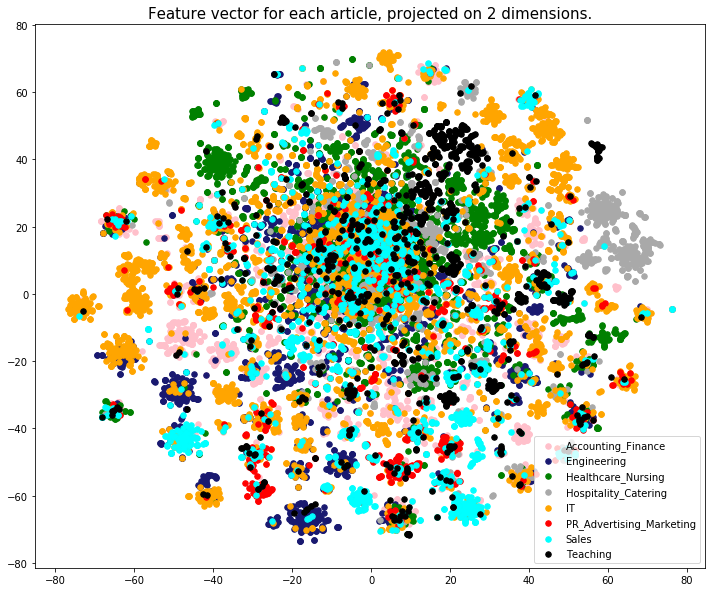

In [ ]:
# RUN THIS REMOTE
# tSNE plot for COUNT VECTOR - ONLY TITLE
print("The following tSNE plot is for count vector(title_count_features) for title only vs job categories: ")
plot_TSNE(data['category'],title_count_features.toarray())

In [80]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(title_count_features, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
title_count_feature_model = LogisticRegression(max_iter = 5000, random_state = seed)
title_count_feature_model.fit(X_train, y_train)
title_count_feature_model.score(X_test, y_test)

0.754303513853216

### 3.4.2 Combine title and description

In [81]:
data["title_desc"] = data['tk_clean_title'] + data['tk_desc']
# data["title_desc"]

In [ ]:
data.to_csv('/content/drive/My Drive/pickle-data/title_desc_pickle/data.csv')

In [82]:
#Generate vocabulary for title
combined_nested_list = data['title_desc']
combined_single_list = list(chain.from_iterable(combined_nested_list)) # we put all the tokens in the corpus in a single list
combined_vocab = set(combined_single_list)
# print("combined_vocab",combined_vocab)
print("length of combined_vocab: ",len(combined_vocab))

length of combined_vocab:  40248


In [ ]:
# Pickle out data with combined title and desc
pickle_out = open("/content/drive/My Drive/pickle-data/title_desc_pickle/combined_nested_list.pickle", "wb")
pickle.dump(combined_nested_list, pickle_out)

In [ ]:
pickle_in = open("/content/drive/My Drive/pickle-data/title_desc_pickle/combined_nested_list.pickle", "rb")
combined_nested_list = pickle.load(pickle_in)

In [83]:
joined_title_desc = [' '.join(words) for words in combined_nested_list]
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = combined_vocab) # initialised the CountVectorizer
combined_count_features = cVectorizer.fit_transform(joined_title_desc)
combined_count_features.shape

(55449, 40248)

In [ ]:
# Pickle out data with clean title
pickle_out = open("/content/drive/My Drive/pickle-data/title_desc_pickle/combined_count_features.pickle", "wb")
pickle.dump(combined_count_features, pickle_out)

In [ ]:
pickle_in = open("/content/drive/My Drive/pickle-data/title_desc_pickle/combined_count_features.pickle", "rb")
combined_count_features = pickle.load(pickle_in)

In [ ]:
# data = pd.read_csv('title_desc_pickle/data.csv', index_col=0)

# pickle_in = open("title_desc_pickle/combined_count_features.pickle", "rb")
# combined_count_features = pickle.load(pickle_in)

The following tSNE plot is for count vector(combined_count_features) for title & description both vs job categories: 


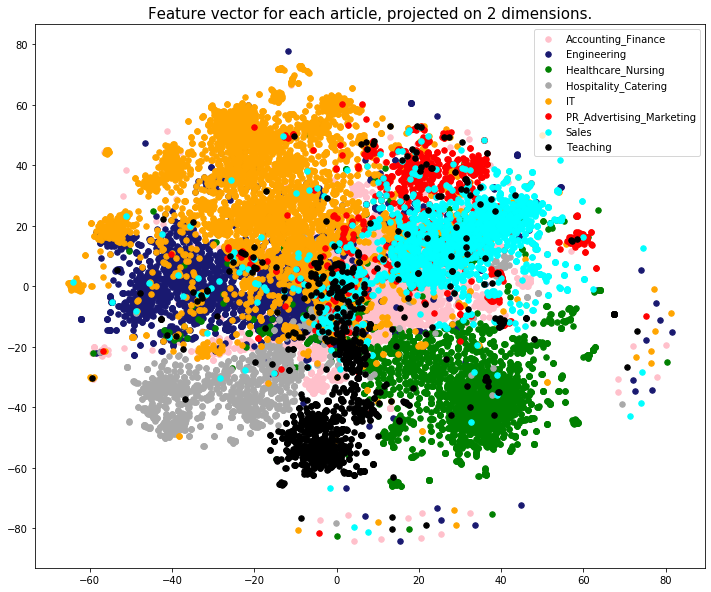

In [ ]:
# # RUN THIS REMOTE
# tSNE plot for COUNT VECTOR - title & desc both
print("The following tSNE plot is for count vector(combined_count_features) for title & description both vs job categories: ")
plot_TSNE(data['category'],combined_count_features.toarray())

In [84]:
seed = 0
X_train,X_test,y_train, y_test, train_indices, test_indices = train_test_split(combined_count_features, data['category'], list(range(0, len(data))), test_size = 0.33, random_state = seed)
combined_count_feature_model = LogisticRegression(max_iter = 5000, random_state = seed)
combined_count_feature_model.fit(X_train, y_train)
combined_count_feature_model.score(X_test, y_test)

0.877261052516531

| Information provided to the Model| Accuracy |
|:-|:-|
| With only Title| 75.43% |
| With only Description | 87.57% |
| With Both Title & Description| 87.72% |

# Summary
From the outputs obtained after performing task 2 and task 3 following points could be concluded:

* **Task 2**: There were total 7 different type of feature representations of dcocuments built including count vector, two FastText embeddings (one TF-IDF weighted, and one unweighted version), four pre-trained embeddings (2 different pre-trained language models, each has one TF-IDF weighted version, and one unweighted version.
 
* **Task 3**: 
  * From the t-distributed stochastic neighbor embedding (t-SNE) visualisations, GoogleNews300 and Glove were not able to catgorise the job categories properly, weheras glove TF-IDF weighted was somewhat able to form clusters, and all the other remaining features representations including count vectors, GoogleNews300 TF-IDF, FastText TF-IDF and FastText unweighted were forming the best clusters. 
  * The best language model amongst all vector embeddings including (count vector, FastText weighted, Glove weighted, GoogleNews300 weighted, FastText unweighted, glove unweighted, GoogleNews300 unweighted) after performing 5-fold cross validation was found to be count vector language model returning an accuracy of 87.57% and the second best model was FastText TF-IDF weighted with an accuracy of 86.73%. 
  * When only Title was considered to build the language model with the count vectors feature representation to classify documents based on the job categories, it was found that the model was only 75.43% accurate. This was also evident from the visual t-SNE plot as it was unable to form distinguishable clusters. Whereas, with only description, it attained 87.53% accuracy as mentioned in the previous point.
  * After combining both title and job description together to classify documents based on the job categories, it was observed that it gave slightly better results and returned an accuracy of 87.72%. Therefore, it can be concluded that the language model built with the help of count vector feature representation performs better when extra information is feeded to the model and improves the overall result.

## Couple of notes for all code blocks in this notebook
- There are pickle_in and pickle_out files to easily access the models rather than re-runnning the notebook. 
